# Import libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import logging

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from catboost import Pool

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


# Loading the data

In [4]:
# Read the dataset from a CSV file using Pandas
df = pd.read_csv("/kaggle/input/optiver-trading-at-the-close/train.csv")

# Remove rows with missing values in the "target" column
df = df.dropna(subset=["target"])

# Reset the index of the DataFrame and apply the changes in place
df.reset_index(drop=True, inplace=True)

In [5]:
# Get the shape of the DataFrame (number of rows and columns)
print(df.shape)

(5237892, 17)


In [6]:
df.head(3)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0,0_0_2


In [7]:
df.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
row_id                      object
dtype: object

# Optimizing the memory usage

The dataframe is not optimized, we can use less memory. We will take a method to do this.

Source: https://www.kaggle.com/code/verracodeguacas/fold-cv#%F0%9F%A7%B9-Importing-necessary-libra

In [8]:
# Function to reduce memory usage of a Pandas DataFrame
def reduce_mem_usage(df, verbose=1):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    
    # Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    # Provide memory optimization information if 'verbose' is True
    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    # Return the DataFrame with optimized memory usage
    return df

In [9]:
df = reduce_mem_usage(df, verbose=1)

Memory usage of dataframe is 679.35 MB
Memory usage after optimization is: 304.71 MB
Decreased by 55.15%


# Split the data on the train and the valid part

In [10]:
split_day = 430
df_train = df[df["date_id"] < split_day]
df_valid = df[df["date_id"] >= split_day]

In [11]:
not_features = ['row_id', 'time_id', 'target']
features = [col for col in df.columns if col not in not_features]
print(features)

['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']


In [12]:
df_train = df.dropna(subset=["target"])
df_train.reset_index(drop=True, inplace=True)

X = df_train[features].copy(deep=True)
y = df_train['target'].copy(deep=True)

In [13]:
len(X["date_id"].unique())

481

In [14]:
days = len(X.date_id.unique()) 
# There are 481 trading days, take the last n as testing
testing_days = 20
training_days = days - testing_days
training_days, testing_days

(461, 20)

In [15]:
# create mask for days
training_mask = X["date_id"] <= training_days
testing_mask = X["date_id"] > training_days

In [16]:
# subset and make training and validation sets
X_train, X_val, y_train, y_val = X[training_mask], X[testing_mask], y[training_mask], y[testing_mask]
#train_test_split(X, y, test_size=0.20, random_state=0, shuffle=True, stratify=X['stock_id']) # random_state=8
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5028892, 14), (209000, 14), (5028892,), (209000,))

In [17]:
def feature_engineering(X):

    _X = X.copy()

    # features engineering. source: https://www.kaggle.com/code/zulqarnainali/explained-singel-model-optiver
    _X["liquidity_imbalance"] = _X.eval("(bid_size - ask_size) / (bid_size + ask_size)")
    _X["matched_imbalance"] = _X.eval("(imbalance_size - matched_size) / (matched_size + imbalance_size)")
    _X["price_spread"] = _X["ask_price"] - _X["bid_price"]
    _X["market_urgency"] = _X["price_spread"] * _X["liquidity_imbalance"]
    
    return _X.drop(columns=["date_id"])

In [18]:
%%time 

# apply feature engineering
X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)

X_train.shape, X_val.shape

CPU times: user 399 ms, sys: 261 ms, total: 660 ms
Wall time: 591 ms


((5028892, 17), (209000, 17))

In [19]:
train_pool = Pool(data=X_train, label=y_train)
val_pool = Pool(data=X_val, label=y_val)

In [21]:
params = dict(
    loss_function="MAE",
    eval_metric="MAE",
    metric_period=100,
    bootstrap_type="Bernoulli",
    od_type="Iter",
    od_wait=20,
    border_count=32,
    task_type="CPU", # "GPU",
    random_seed=42,
    iterations=600,
    subsample=0.78,
    random_strength=11.285714149475098,
    depth=8,
    l2_leaf_reg=33,
    learning_rate=0.012
)


model = CatBoostRegressor(**params)

In [22]:
%%time

# https://medium.com/analytics-vidhya/catboost-101-fb2fdc3398f3
final_params = params.copy()
# updates = dict()
# final_params.update(updates)
# print(final_params)
final_model = CatBoostRegressor(**final_params)
final_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val)
)

print("-----Predicting with the reduced set model-----------")
y_val_pred = final_model.predict(X_val)
y_val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"MAE on validation set: {y_val_mae:.4f}")

0:	learn: 6.4317788	test: 5.7801246	best: 5.7801246 (0)	total: 1.28s	remaining: 12m 47s
100:	learn: 6.3574987	test: 5.7293539	best: 5.7293539 (100)	total: 1m 40s	remaining: 8m 15s
200:	learn: 6.3407465	test: 5.7194736	best: 5.7194736 (200)	total: 3m 15s	remaining: 6m 29s
300:	learn: 6.3335498	test: 5.7151899	best: 5.7151899 (300)	total: 4m 51s	remaining: 4m 49s
400:	learn: 6.3290349	test: 5.7125666	best: 5.7125666 (400)	total: 6m 26s	remaining: 3m 11s
500:	learn: 6.3253344	test: 5.7103609	best: 5.7103609 (500)	total: 8m 2s	remaining: 1m 35s
599:	learn: 6.3221383	test: 5.7085756	best: 5.7085756 (599)	total: 9m 36s	remaining: 0us

bestTest = 5.708575621
bestIteration = 599

-----Predicting with the reduced set model-----------
MAE on validation set: 5.7086
CPU times: user 25min 44s, sys: 10.8 s, total: 25min 55s
Wall time: 9min 38s


In [23]:
for key,value in final_model.get_all_params().items():
    print('{}, {}'.format(key,value))

nan_mode, Min
eval_metric, MAE
iterations, 600
sampling_frequency, PerTree
leaf_estimation_method, Exact
od_pval, 0
random_score_type, NormalWithModelSizeDecrease
grow_policy, SymmetricTree
penalties_coefficient, 1
boosting_type, Plain
model_shrink_mode, Constant
feature_border_type, GreedyLogSum
bayesian_matrix_reg, 0.10000000149011612
eval_fraction, 0
force_unit_auto_pair_weights, False
l2_leaf_reg, 33
random_strength, 11.285714149475098
od_type, Iter
rsm, 1
boost_from_average, True
model_size_reg, 0.5
pool_metainfo_options, {'tags': {}}
subsample, 0.7799999713897705
use_best_model, True
od_wait, 20
random_seed, 42
depth, 8
posterior_sampling, False
border_count, 32
classes_count, 0
auto_class_weights, None
sparse_features_conflict_fraction, 0
leaf_estimation_backtracking, AnyImprovement
best_model_min_trees, 1
model_shrink_rate, 0
min_data_in_leaf, 1
loss_function, MAE
learning_rate, 0.012000000104308128
score_function, Cosine
task_type, CPU
leaf_estimation_iterations, 1
bootstrap_t

# Final predictions

In [24]:
import optiver2023
env = optiver2023.make_env()
iter_test = env.iter_test()

In [25]:
for (test, revealed_targets, sample_prediction) in iter_test:
    X_test = test[features].copy(deep=True)
    X_test = feature_engineering(X_test)
    
    sample_prediction["target"] = final_model.predict(X_test)
    env.predict(sample_prediction)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


array([[<Axes: title={'center': 'target'}>]], dtype=object)

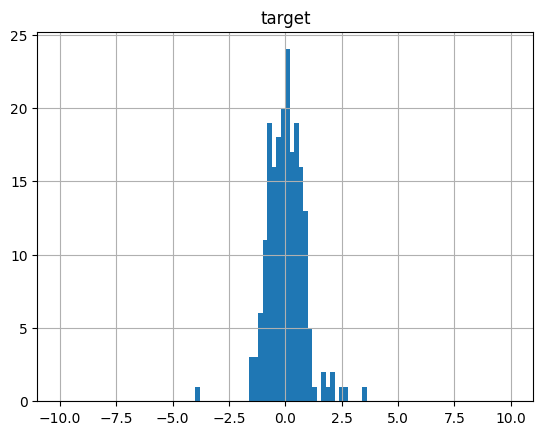

In [26]:
sample_prediction.hist(column='target', bins=100, range=[-10,10])

In [27]:
sample_prediction.to_csv('preds.csv')

In [29]:
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/lib/kaggle/gcp.py
/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py
/kaggle/working/preds.csv
/kaggle/working/submission.csv
/kaggle/working/catboost_info/catboost_training.json
/kaggle/working/catboost_info/learn_error.tsv
/kaggle/working/catboost_info/test_error.tsv
/kaggle/working/catboost_info/time_left.tsv
/kaggle/working/catboost_info/test/events.out.tfevents
/kaggle/working/catboost_info/learn/events.out.tfevents
